<a href="https://colab.research.google.com/github/rishubhkhurana/EVA/blob/master/S5/EVAS5v6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Notebook Analysis -- Sixth Version

1. Target -- Increase batch size which will cause more overfitting and will push training and testing accuracy. The idea is to get >99.5% 
2. Result --  Got best Training ACCURACY as 99.247% and validation accuract as 99.51
3. Analysis -- Increasing batch size increased the trainign accuracy and caused a bt overfitting and to counteract that increasing learning rate helped.

## Import Libs


In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import PIL
from PIL import Image
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
from torch.optim.lr_scheduler import StepLR,OneCycleLR

In [4]:
!pip install torchsummary

In [0]:
from torchsummary import summary

## Transforms/Reading Dataset

In [0]:
train_transforms = transforms.Compose([transforms.ToTensor()])
test_transforms = transforms.Compose([transforms.ToTensor()])

In [0]:
train_data=MNIST(root='./data',train=True,transform=train_transforms,download=True)
test_data=MNIST(root='./data',train=False,transform=test_transforms,download=True)

In [0]:
print(f"Training Dataset Mean: {train_data.transform(train_data.train_data.numpy()).float().mean()}")
print(f"Training Dataset Mean: {train_data.transform(train_data.train_data.numpy()).float().std()}")

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


Training Dataset Mean: 0.13054245710372925
Training Dataset Mean: 0.30810782313346863


In [0]:
print(f"Testing Dataset Mean: {train_data.transform(train_data.train_data.numpy()).float().mean()}")
print(f"Testing Dataset Mean: {test_data.transform(test_data.train_data.numpy()).float().std()}")

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


Testing Dataset Mean: 0.13054245710372925
Testing Dataset Mean: 0.3104802668094635


In [0]:
train_transforms = transforms.Compose([transforms.RandomRotation((-5.0, 5.0), fill=(1,)),
                                       #transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1305,),(0.308,))])
test_transforms = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.1305,),(0.308,))])

In [7]:
train_data=MNIST(root='./data',train=True,transform=train_transforms,download=True)
test_data=MNIST(root='./data',train=False,transform=test_transforms,download=True)


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


In [0]:
#print(f"Training Dataset Mean: {train_data.transform(train_data.train_data.numpy()).float().mean()}")
#print(f"Training Dataset Mean: {train_data.transform(train_data.train_data.numpy()).float().std()}")

In [9]:
print(f"Testing Dataset Mean: {test_data.transform(test_data.train_data.numpy()).float().mean()}")
print(f"Testing Dataset Mean: {test_data.transform(test_data.train_data.numpy()).float().std()}")

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


Testing Dataset Mean: 0.0064513590186834335
Testing Dataset Mean: 1.0080528259277344


## Defining Data Loader


In [0]:
# defining the seed for reproducible
SEED = 99

torch.manual_seed(SEED)

# checking if the CUDA is available 

is_CUDA = torch.cuda.is_available()

if is_CUDA:
  dev = torch.device('cuda')
else:
  dev = torch.device('cpu')



In [0]:
BATCH_SIZE=256
EPOCHS=15

In [0]:
dataloader_args = dict(shuffle=True,batch_size=BATCH_SIZE,pin_memory=True,num_workers=4) if is_CUDA else dict(shuffle=True,batch_size=BATCH_SIZE//2)
train_dl = DataLoader(train_data,**dataloader_args)

dataloader_args = dict(shuffle=False,batch_size=BATCH_SIZE*2,pin_memory=True,num_workers=4) if is_CUDA else dict(shuffle=False,batch_size=BATCH_SIZE)
test_dl = DataLoader(test_data,**dataloader_args)

In [0]:
x,y=next(iter(train_dl))

In [14]:
x.size(),y.size()

(torch.Size([128, 1, 28, 28]), torch.Size([128]))

In [0]:
torch.Tensor.stats = lambda x: (x.mean(),x.std())

In [16]:
x.stats()

(tensor(0.0284), tensor(1.0290))

In [17]:
type(x)

torch.Tensor

In [18]:
train_dl.dataset.transforms

StandardTransform
Transform: Compose(
               RandomRotation(degrees=(-5.0, 5.0), resample=False, expand=False)
               ToTensor()
               Normalize(mean=(0.1305,), std=(0.308,))
           )

## Visualizing the data

In [0]:
def plot_img(img,axs=None,figsize=(6,6),visible=True):
  if axs is None:
    _,axs=plt.subplots(1,1,figsize=figsize)
  if not visible:
    #print("yesy")
    axs.set_xticks([])
    axs.set_yticks([])
  axs.imshow(img.numpy().squeeze(0),cmap='gray_r')
  
  

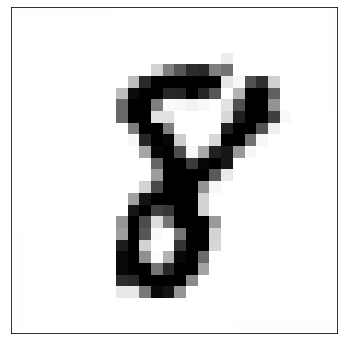

In [0]:
plot_img(x[0],visible=False)

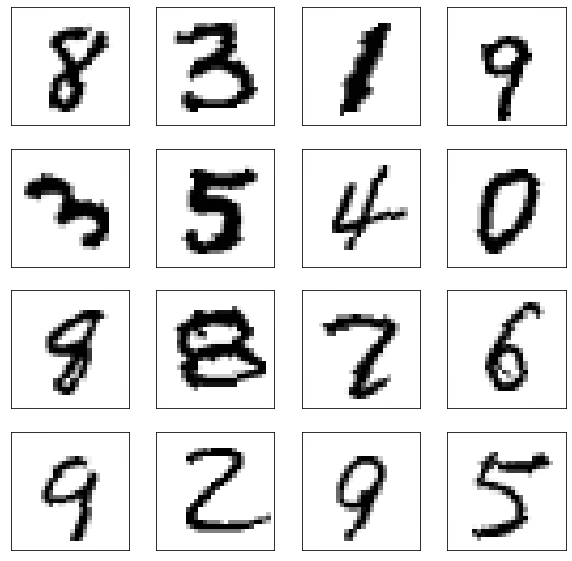

In [0]:
fig,axs = plt.subplots(4,4,figsize=(10,10))
for i,ax in enumerate(axs.ravel()):
  plot_img(x[i],axs=axs[i//4,i%4],visible=False)

## Defining Model

In [0]:
class Model(nn.Module):
  def __init__(self,p=0.1,use_bias=True):
    super().__init__()
    self.alllyrs=nn.Sequential()
    cblock1 = []
    cblock1.append(nn.Sequential(*[nn.Conv2d(1,12,kernel_size=(3,3),stride=1,bias=use_bias),nn.BatchNorm2d(12),nn.ReLU(),nn.Dropout(p=p)])) # output_size=26,RF=3
    cblock1.append(nn.Sequential(*[nn.Conv2d(12,24,kernel_size=(3,3),stride=1,bias=use_bias),nn.BatchNorm2d(24),nn.ReLU(),nn.Dropout(p=p)])) # output_size=24,RF=5
    self.cblock1 = nn.Sequential(*cblock1)
    tblock1=[]
    tblock1.append(nn.MaxPool2d((2,2))) # output_size=12, RF=6
    tblock1.append(nn.Sequential(*[nn.Conv2d(24,12,kernel_size=(1,1),stride=1,bias=use_bias),nn.BatchNorm2d(12),nn.ReLU(),nn.Dropout(p=p)])) # output_size=12,RF=6
    self.tblock1=nn.Sequential(*tblock1)
    cblock2 = []
    cblock2.append(nn.Sequential(*[nn.Conv2d(12,12,kernel_size=(3,3),stride=1,bias=use_bias),nn.BatchNorm2d(12),nn.ReLU(),nn.Dropout(p=p)])) # output_size=10,RF=10
    cblock2.append(nn.Sequential(*[nn.Conv2d(12,12,kernel_size=(3,3),stride=1,bias=use_bias),nn.BatchNorm2d(12),nn.ReLU(),nn.Dropout(p=p)])) # output_size=8,RF=14
    cblock2.append(nn.Sequential(*[nn.Conv2d(12,12,kernel_size=(3,3),stride=1,bias=use_bias),nn.BatchNorm2d(12),nn.ReLU(),nn.Dropout(p=p)])) # output_size=6,RF=18
    cblock2.append(nn.Sequential(*[nn.Conv2d(12,12,kernel_size=(3,3),stride=1,bias=use_bias),nn.BatchNorm2d(12),nn.ReLU(),nn.Dropout(p=p)])) # output_size=4,RF=22
    cblock2.append(nn.Sequential(*[nn.Conv2d(12,12,kernel_size=(3,3),stride=1,bias=use_bias),nn.BatchNorm2d(12),nn.ReLU(),nn.Dropout(p=p)])) # output_size=4,RF=26

    self.cblock2 = nn.Sequential(*cblock2)
    tblock2=[]
    tblock2.append(nn.AdaptiveAvgPool2d((1,1)))
    tblock2.append(nn.Conv2d(12,10,kernel_size=(1,1),stride=1))
    self.tblock2=nn.Sequential(*tblock2)
  def forward(self,x):
    x = self.cblock1(x)
    x = self.tblock1(x)
    x = self.cblock2(x)
    x = self.tblock2(x)
    return F.log_softmax(x).squeeze().squeeze()


In [0]:
mod=Model(use_bias=False).cuda()

In [0]:
#mod

In [45]:
summary(model=mod,input_size=(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 12, 26, 26]             108
       BatchNorm2d-2           [-1, 12, 26, 26]              24
              ReLU-3           [-1, 12, 26, 26]               0
           Dropout-4           [-1, 12, 26, 26]               0
            Conv2d-5           [-1, 24, 24, 24]           2,592
       BatchNorm2d-6           [-1, 24, 24, 24]              48
              ReLU-7           [-1, 24, 24, 24]               0
           Dropout-8           [-1, 24, 24, 24]               0
         MaxPool2d-9           [-1, 24, 12, 12]               0
           Conv2d-10           [-1, 12, 12, 12]             288
      BatchNorm2d-11           [-1, 12, 12, 12]              24
             ReLU-12           [-1, 12, 12, 12]               0
          Dropout-13           [-1, 12, 12, 12]               0
           Conv2d-14           [-1, 12,

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


## Training Loop Design

In [0]:
# basic loop structure

def one_epoch(model,trn_dl,val_dl,opt,device='cpu'):
  # variables to keep track off during one epoch
  bcount=0
  tlosses=0
  tacc=0
  # put model in training mode
  model.train()
  # define a progress bar
  pbar = tqdm(trn_dl)
  # loop through every batch in dataloader
  for batch_index,(xb,yb) in enumerate(pbar):
    # move the data to cpu or gpu based on device arg
    xb,yb=xb.to(device),yb.to(device)
    bs = xb.shape[0]
    # clean the gradients of parameters computed in the previous batch
    opt.zero_grad()
    # predict the batch
    preds = model(xb)
    # compute batch loss
    loss = F.nll_loss(preds,yb)
    # append the current loss to list
    tlosses+=loss*bs
    # call back propagation
    loss.backward()
    # call the optimization step
    opt.step()
    # compute the current model accuracy
    y_preds=preds.argmax(dim=1,keepdim=True)
    # compute current accuracy of the training batch and add it to the total count of accurate results
    tacc+= y_preds.eq(yb.view_as(y_preds)).sum().item()
    bcount+=bs
    # add progress bar description with current batch loss and moving average of training accuracy
    pbar.set_description(desc=f'Loss={loss.item():.3f} batch-index={batch_index} Accuracy={100*tacc/bcount:0.2f}')
  
  # compute the updated training loss and accuracy for entire batch
  tlosses/=bcount
  tacc/=bcount

  # loop through validation data and compute the metrics on validation data
  model.eval()
  vloss=0
  vacc=0
  vcount=0
  with torch.no_grad():
    for xb,yb in tqdm(val_dl):
      bs = xb.shape[0]
      xb,yb = xb.to(device),yb.to(device)
      preds = model(xb)
      loss = F.nll_loss(preds,yb,reduction='sum')
      y_preds = preds.argmax(dim=1,keepdim=True)
      vacc+=y_preds.eq(yb.view_as(y_preds)).sum().item()
      vcount+=bs
      vloss+=loss.item()
  vloss/=vcount
  vacc/=vcount
  return {'TrainingLoss':tlosses,'ValidationLoss':vloss,'TrainingAcc':tacc,'ValidationAcc':vacc}








## Training the Model

In [64]:
mod=Model(p=0.05,use_bias=False).cuda()

opt = optim.SGD(mod.parameters(),lr=0.1,momentum=0.9)
scheduler = StepLR(opt, step_size=5, gamma=0.3)

for e in range(EPOCHS):
  ldict=one_epoch(mod,train_dl,test_dl,opt,device=dev)
  scheduler.step()
  if e%5==0:
    print(f"\nCurrent Learning Rate: {opt.param_groups[-1]['lr']}")
  print(f'\nEpoch:{e}--> Training Loss:{ldict["TrainingLoss"]:.3f}, Validation Loss:{ldict["ValidationLoss"]:.3f}\n')
  print(f'Training Accuracy:{100*ldict["TrainingAcc"]:.3f}, Validation Accuracy:{100*ldict["ValidationAcc"]:.3f}\n')

  

  0%|          | 0/235 [00:00<?, ?it/s]


Current Learning Rate: 0.1

Epoch:0--> Training Loss:0.284, Validation Loss:0.063

Training Accuracy:91.558, Validation Accuracy:98.030



  0%|          | 0/235 [00:00<?, ?it/s]


Epoch:1--> Training Loss:0.071, Validation Loss:0.038

Training Accuracy:97.850, Validation Accuracy:98.810



  0%|          | 0/235 [00:00<?, ?it/s]


Epoch:2--> Training Loss:0.060, Validation Loss:0.036

Training Accuracy:98.173, Validation Accuracy:98.760



  0%|          | 0/235 [00:00<?, ?it/s]


Epoch:3--> Training Loss:0.051, Validation Loss:0.030

Training Accuracy:98.427, Validation Accuracy:99.050



  0%|          | 0/235 [00:00<?, ?it/s]


Epoch:4--> Training Loss:0.047, Validation Loss:0.028

Training Accuracy:98.592, Validation Accuracy:99.180



  0%|          | 0/235 [00:00<?, ?it/s]


Current Learning Rate: 0.03

Epoch:5--> Training Loss:0.036, Validation Loss:0.021

Training Accuracy:98.887, Validation Accuracy:99.360



  0%|          | 0/235 [00:00<?, ?it/s]


Epoch:6--> Training Loss:0.032, Validation Loss:0.020

Training Accuracy:98.990, Validation Accuracy:99.390



  0%|          | 0/235 [00:00<?, ?it/s]


Epoch:7--> Training Loss:0.032, Validation Loss:0.021

Training Accuracy:99.028, Validation Accuracy:99.360



  0%|          | 0/235 [00:00<?, ?it/s]


Epoch:8--> Training Loss:0.030, Validation Loss:0.019

Training Accuracy:99.083, Validation Accuracy:99.460



  0%|          | 0/235 [00:00<?, ?it/s]


Epoch:9--> Training Loss:0.030, Validation Loss:0.019

Training Accuracy:99.092, Validation Accuracy:99.390



  0%|          | 0/235 [00:00<?, ?it/s]


Current Learning Rate: 0.009

Epoch:10--> Training Loss:0.027, Validation Loss:0.018

Training Accuracy:99.145, Validation Accuracy:99.510



  0%|          | 0/235 [00:00<?, ?it/s]


Epoch:11--> Training Loss:0.026, Validation Loss:0.018

Training Accuracy:99.180, Validation Accuracy:99.460



  0%|          | 0/235 [00:00<?, ?it/s]


Epoch:12--> Training Loss:0.026, Validation Loss:0.019

Training Accuracy:99.217, Validation Accuracy:99.430



  0%|          | 0/235 [00:00<?, ?it/s]


Epoch:13--> Training Loss:0.025, Validation Loss:0.018

Training Accuracy:99.233, Validation Accuracy:99.470



100%|██████████| 20/20 [00:01<00:00, 13.31it/s]


Epoch:14--> Training Loss:0.025, Validation Loss:0.018

Training Accuracy:99.247, Validation Accuracy:99.450



In [57]:
len(train_dl)//BATCH_SIZE

3